In [3]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from Machine_Learning import ML_Crosstalk

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [4]:
qubits = 2
date = "2024-09-05_18-52"
location = "C:\Projects\Crosstalk\Machine_Learning\Data/" + date

train_df = ML_Crosstalk.load_training_data(location)
test_df = ML_Crosstalk.load_test_data(location)

train_df.head()
print(len(train_df))

11000


In [8]:
learning_rate = 0.0001
epochs = 1000
batch_size = 500

output_keys, input_keys = ML_Crosstalk.get_keys(train_df, qubits) #Reversed


inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in input_keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = ML_Crosstalk.build_model(concatenated_inputs, len(nodes_per_layer), output_keys, nodes_per_layer)

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decay_0             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decay_1             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_0 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_1 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ J_0 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5)         │          0 │ decay_0[0][0],    │
│ (Concatenate)       │                   │            │ decay_1[0][0],    │
│                     │                   │            │ W_0[0][0],        │
│                     │                   │            │ W_1[0][0],        │
│                     │                   │            │ J_0[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │        192 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      2,112 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      4,160 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      4,160 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      4,160 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      4,160 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      4,160 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 8)         │        520 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 8)         │         72 │ dense_25[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,696 (92.56 KB)

 Trainable params: 23,696 (92.56 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0361 - val_loss: 0.0379
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0364 - val_loss: 0.0380
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - val_loss: 0.0382
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - val_loss: 0.0380
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - val_loss: 0.0379
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0363 - val_loss: 0.0378
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - val_loss: 0.0379
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - val_loss: 0.0379
Epoch 9/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - val_loss: 0.0378
Epoch 10/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - val_loss: 0.0378
Epoch 11/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0367 - val_loss: 0.0379
Epoch 12/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

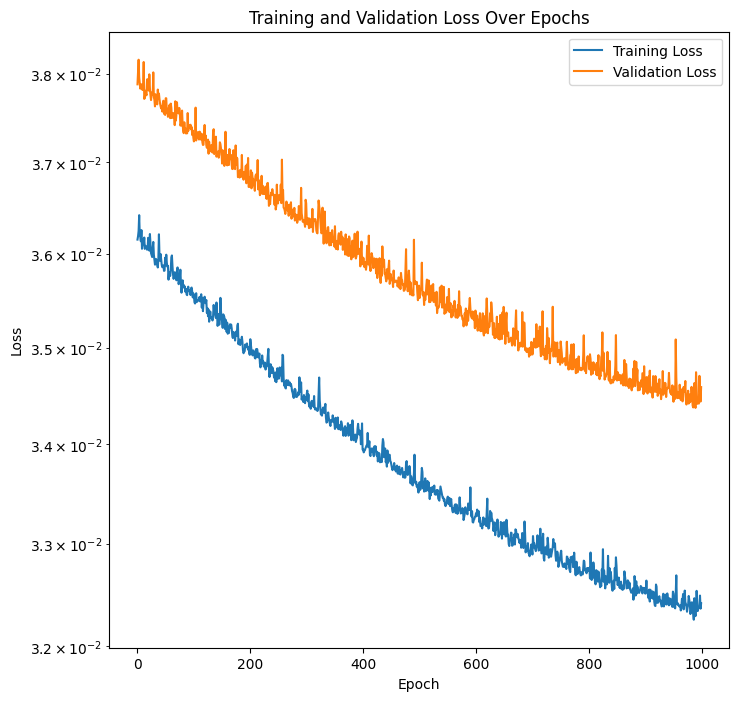

In [20]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [22]:
import numpy as np
import estimator

new_data = test_df
first_line = new_data.iloc[0]
correct_output = first_line[output_keys].array

input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

parameters = {key: first_line[key] for key in input_keys}
print(parameters)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted values:  [ 0.2461611   0.5754392   0.66770566  0.40238345  0.6182007  -0.77583736
  0.6746354  -0.6378414 ]
Correct values:  <PandasArray>
[0.2632, 0.06, 0.6936, 0.416, 0.5944, -0.7248, 0.6704, -0.6464]
Length: 8, dtype: float64
the mean squared error is:  0.2700863104990135
The percent error is:  31.967452746380054
{'decay_0': 0.3480902073960761, 'decay_1': 0.5109837437398793, 'W_0': 1.8329128005445756, 'W_1': -1.4583094164215875, 'J_0': -0.5820463809770197}


In [25]:
import tensorflow as tf

target_outputs = tf.constant(correct_output, dtype=tf.float32)  # Replace with your target values

# Initialize the input parameters as variables to optimize
initial_guess = {
    'decay_0': 0.5,
    'decay_1': 0.5,
    'W_0': 0,
    'W_1': 0,
    'J_0': 0
}
input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}


# Use the variables as inputs to the model
def model_loss(target):
    # Pass the variables through the model to get the predicted output
    model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
    predicted_outputs = model(model_inputs, training=False)

    # Calculate the loss between predicted and target outputs
    loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
    return loss * 1000


# Set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Optimization loop
for step in range(1000):  # Adjust the number of steps as needed
    with tf.GradientTape() as tape:
        loss = model_loss(target_outputs)
    # Compute the gradients of the loss with respect to the input variables
    grads = tape.gradient(loss, input_vars.values())
    # input_vars['J_0'].assign(-0.64)
    # Apply the gradients to the input variables
    optimizer.apply_gradients(zip(grads, input_vars.values()))

    # Print the loss and current input variables every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")

# Final optimized input parameters
optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}
print("Optimized Inputs:", optimized_inputs)
print(parameters)

Step 0, Loss: 412.4517822265625, Inputs: [0.50999993, 0.50999993, 0.009999932, -0.009999932, 0.009999932]
Step 100, Loss: 139.08934020996094, Inputs: [0.31862938, 0.47611105, 0.80124104, -1.0821987, 0.53443396]
Step 200, Loss: 91.56686401367188, Inputs: [0.17183511, 0.5227009, 1.1440156, -1.5027691, 0.23881742]
Step 300, Loss: 76.78779602050781, Inputs: [0.28487554, 0.52587175, 1.35597, -1.4585518, -0.07782477]
Step 400, Loss: 71.41888427734375, Inputs: [0.3353794, 0.521162, 1.4550234, -1.4362357, -0.22259825]
Step 500, Loss: 70.54026794433594, Inputs: [0.33161205, 0.52499455, 1.4540898, -1.4392192, -0.22064202]
Step 600, Loss: 70.51154327392578, Inputs: [0.33096123, 0.5224604, 1.4542042, -1.4450185, -0.21941595]
Step 700, Loss: 70.6102523803711, Inputs: [0.33100072, 0.5202345, 1.4531524, -1.4401112, -0.21827777]
Step 800, Loss: 70.56389617919922, Inputs: [0.33162886, 0.5223841, 1.4534392, -1.4411885, -0.21855053]
Step 900, Loss: 70.67082214355469, Inputs: [0.3299195, 0.52512187, 1.454

In [26]:


print(list(optimized_inputs.values()))
print(list(parameters.values()))

error = estimator.percent_error(np.array(list(optimized_inputs.values())), np.array(list(parameters.values())))
print(error * 100)

[0.331771, 0.5270149, 1.457037, -1.4416089, -0.2240479]
[0.3480902073960761, 0.5109837437398793, 1.8329128005445756, -1.4583094164215875, -0.5820463809770197]
29.195879223454675


In [27]:
errors = []
for i in range(10):
    line = new_data.iloc[i]
    correct_output = line[output_keys].array
    parameters = {key: line[key] for key in input_keys}
    input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)


    def model_loss(target):
        # Pass the variables through the model to get the predicted output
        model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
        predicted_outputs = model(model_inputs, training=False)

        # Calculate the loss between predicted and target outputs
        loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
        return loss


    for step in range(500):  # Adjust the number of steps as needed
        with tf.GradientTape() as tape:
            loss = model_loss(correct_output)

        # Compute the gradients of the loss with respect to the input variables
        grads = tape.gradient(loss, input_vars.values())

        # Apply the gradients to the input variables
        optimizer.apply_gradients(zip(grads, input_vars.values()))

        # Print the loss and current input variables every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")
            print(np.array(list(parameters.values())))

    optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}

    optimized_inputs = np.array(list(optimized_inputs.values()))
    parameters = np.array(list(parameters.values()))

    # optimized_inputs = optimized_inputs[:-1]
    # parameters = parameters[:-1]

    error = estimator.percent_error(optimized_inputs, parameters)
    errors.append(error)
    print("Error is: ", error * 100)
print("The mean percent error is: ", np.mean(errors) * 100)

Step 0, Loss: 0.41245177388191223, Inputs: [0.59999716, 0.5999931, 0.09999642, -0.099994466, 0.099994235]
[ 0.34809021  0.51098374  1.8329128  -1.45830942 -0.58204638]
Step 100, Loss: 0.07781855762004852, Inputs: [0.35610694, 0.5200709, 1.4551126, -1.3986478, -0.23151843]
[ 0.34809021  0.51098374  1.8329128  -1.45830942 -0.58204638]
Step 200, Loss: 0.07626582682132721, Inputs: [0.33863935, 0.5224977, 1.464713, -1.4144026, -0.19227824]
[ 0.34809021  0.51098374  1.8329128  -1.45830942 -0.58204638]
Step 300, Loss: 0.07764123380184174, Inputs: [0.319847, 0.56393945, 1.4601986, -1.4506003, -0.20236608]
[ 0.34809021  0.51098374  1.8329128  -1.45830942 -0.58204638]
Step 400, Loss: 0.07957300543785095, Inputs: [0.31562367, 0.4998865, 1.4424598, -1.4532113, -0.24860582]
[ 0.34809021  0.51098374  1.8329128  -1.45830942 -0.58204638]
Error is:  31.350312112762296
Step 0, Loss: 0.3414106070995331, Inputs: [0.599997, 0.40000206, 0.09999633, -0.099993065, 0.09999414]
[ 0.59035288  0.42207754  1.30772

In [158]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[10]
correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted values:  0.25585717
Correct values:  <PandasArray>
[ 1.109304248656438, 0.1669449844863293,  1.361796655829442,
  1.612846174712094, -0.643076477415179]
Length: 5, dtype: float64


ValueError: operands could not be broadcast together with shapes (8,) (5,) 

In [118]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [119]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  56.559793507707965


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 